In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [5]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [6]:
labels_train.unique(), labels_test.unique()

(array([ 1.,  0.]), array([ 1.,  0.]))

In [7]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [11]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
from math import log, exp
import math

p_1 = labels_train.mean()
print(p_1)

0.7718446601941747


In [12]:
dtrain = xgb.DMatrix(train, label=labels_train)

In [13]:
from datetime import datetime
from random import seed

num_round = 900

defaults = {
    'objective': 'binary:logistic',
    'silent': True
}

trials = Trials()
the_best = 1000
i = 0

start = datetime.now()


def hyperopt_train_test(params):

    global the_best, i
    
    params["max_depth"] +=1
    params["eta"] = math.exp(params["eta"])
    params["tree_method"] = "gpu_hist"
    params["scale_pos_weight"] = 1/p_1
    params.update(defaults)
    
    r = xgb.cv(params, dtrain, num_round, nfold=7,
               metrics={'logloss', 'auc'},
               early_stopping_rounds=40)
   
    weight = float(r.tail(1)["test-logloss-mean"])
    
    i += 1
    
    if the_best > weight:
        the_best = weight
        print(params, " => ", weight)
        print(r.tail(1))
        print(i, " / ", str(datetime.now() - start))
    
    return weight


space4xgb = {
    'max_depth':        hp.choice('max_depth', range(0, 10)),
    'eta':              hp.uniform('eta', log(0.03), log(0.5)),
    'gamma':            hp.uniform('gamma', 0, 30),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1.0),
    'subsample':        hp.uniform('subsample', 0.2, 1.0)
}


def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': acc, 'status': STATUS_OK}

seed(42)
best = fmin(f, space4xgb, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=1000, trials=trials)

{'colsample_bylevel': 0.5119785736321334, 'colsample_bytree': 0.6248593144198221, 'eta': 0.18039700310837695, 'gamma': 21.985091940756025, 'max_depth': 9, 'subsample': 0.7198110032313076, 'tree_method': 'gpu_hist', 'scale_pos_weight': 1.2955974842767295, 'objective': 'binary:logistic', 'silent': True}  =>  0.4014137142857143
    test-auc-mean  test-auc-std  test-logloss-mean  test-logloss-std  \
22       0.843801      0.024161           0.401414          0.032372   

    train-auc-mean  train-auc-std  train-logloss-mean  train-logloss-std  
22        0.987708       0.001618            0.199493           0.004995  
1  /  0:00:01.375779
{'colsample_bylevel': 0.9200664386169792, 'colsample_bytree': 0.21427344657884312, 'eta': 0.03283700636045042, 'gamma': 6.988500943742743, 'max_depth': 7, 'subsample': 0.3844817839555551, 'tree_method': 'gpu_hist', 'scale_pos_weight': 1.2955974842767295, 'objective': 'binary:logistic', 'silent': True}  =>  0.39890357142857136
     test-auc-mean  test-auc-

In [21]:
param = {'max_depth': 7, 
         'learning_rate': 0.118,
         'gamma': 4.3,
         'colsample_bytree': 0.92,
         'colsample_bylevel': 0.80,
         'subsample': 0.41,
         'objective': 'binary:logistic', 
         'silent': 20,
         'n_estimators': 100} # 0.85 / 0.94

param = {'max_depth': 6, 
         'learning_rate': 0.133,
         'gamma': 6.6,
         'colsample_bytree': 0.94,
         'colsample_bylevel': 0.91,
         'subsample': 0.63,
         'objective': 'binary:logistic', 
         'silent': 20,
         'n_estimators': 800} # 0.863 / 0.946

param = {'max_depth': 9, 
         'learning_rate': 0.1,
         'gamma': 4.6,
         'colsample_bytree': 0.72,
         'colsample_bylevel': 0.966,
         'subsample': 0.71,
         'objective': 'binary:logistic', 
         'silent': 20,
         'n_estimators': 122} # 0.860 / 0.950


rf = xgb.XGBClassifier(class_weight='balanced')
rf = rf.set_params(**param)

pipeline = rf
pipeline.fit(train, labels_train, 
             eval_set=[(test, labels_test), (train, labels_train)],
             eval_metric="logloss",
             verbose=True)

[0]	validation_0-logloss:0.64403	validation_1-logloss:0.641555
[1]	validation_0-logloss:0.60467	validation_1-logloss:0.597646
[2]	validation_0-logloss:0.570674	validation_1-logloss:0.564329
[3]	validation_0-logloss:0.543501	validation_1-logloss:0.535523
[4]	validation_0-logloss:0.519054	validation_1-logloss:0.510307
[5]	validation_0-logloss:0.499176	validation_1-logloss:0.489317
[6]	validation_0-logloss:0.487311	validation_1-logloss:0.475962
[7]	validation_0-logloss:0.470083	validation_1-logloss:0.457963
[8]	validation_0-logloss:0.46217	validation_1-logloss:0.449788
[9]	validation_0-logloss:0.450044	validation_1-logloss:0.435803
[10]	validation_0-logloss:0.438895	validation_1-logloss:0.423735
[11]	validation_0-logloss:0.429909	validation_1-logloss:0.412298
[12]	validation_0-logloss:0.423164	validation_1-logloss:0.402034
[13]	validation_0-logloss:0.418326	validation_1-logloss:0.394432
[14]	validation_0-logloss:0.41665	validation_1-logloss:0.388646
[15]	validation_0-logloss:0.413293	vali

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=0.966, colsample_bytree=0.72, gamma=4.6,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=122, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=20,
       subsample=0.71)

In [22]:
# Evalute random forest classifier on training data (it overfits, small sample size)
y_predict = pipeline.predict(train)
f1 = f1_score(labels_train, y_predict)
print('F1 on train:', f1)

# Evalute random forest classifier on train data
y_predict = pipeline.predict_proba(train)[:,1]
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
f1 = f1_score(labels_test, y_predict)
print('F1 on test:', f1)

# Evalute random forest classifier on test data
y_predict = pipeline.predict_proba(test)[:,1]
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

F1 on train: 0.938574938575
AUC on train: 0.949867523083
F1 on test: 0.877637130802
AUC on test: 0.860540206649


0.7601809954751131


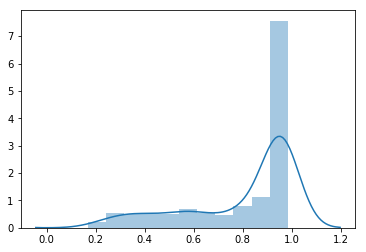

In [23]:
import seaborn as sns
%matplotlib inline

print(labels_test.mean())

sns.distplot(y_predict)

In [23]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

Couples probability of staying together: 0.922255


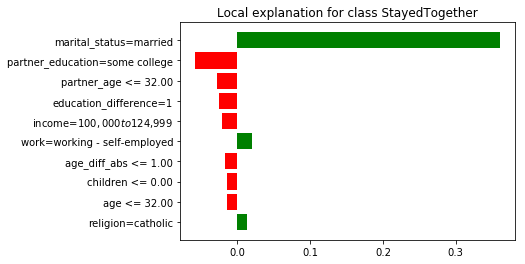

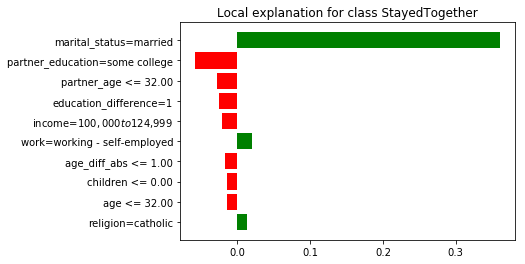

In [24]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.908843


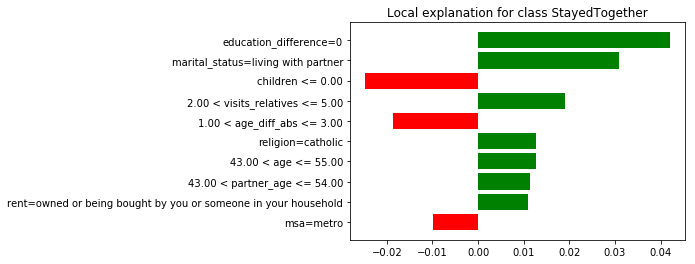

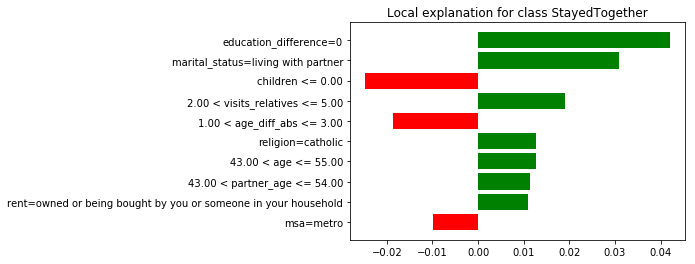

In [25]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [26]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.776331


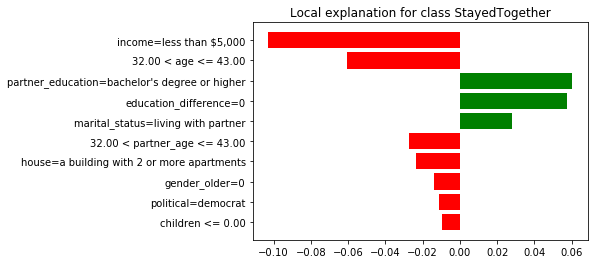

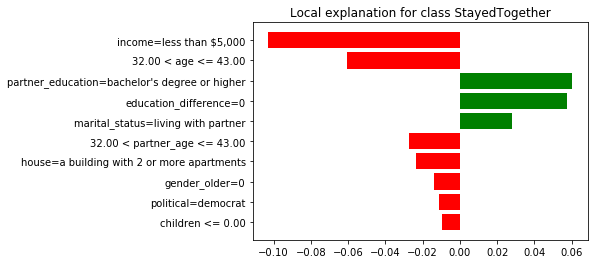

In [27]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.806007


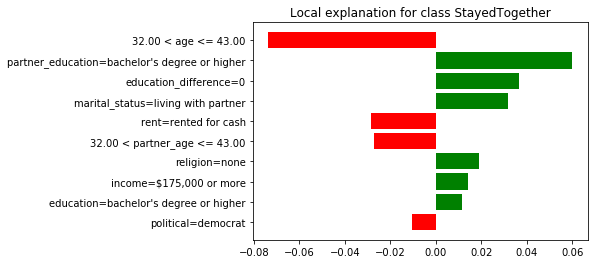

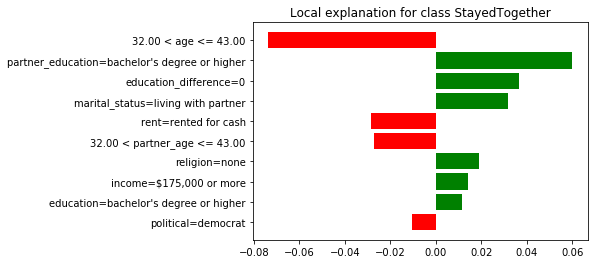

In [28]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.806007


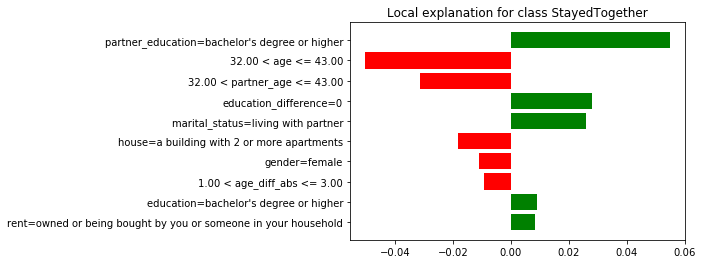

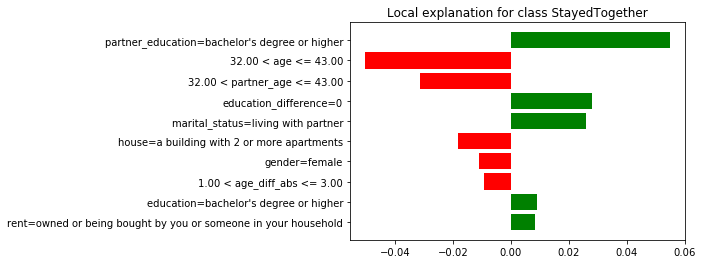

In [29]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.950146


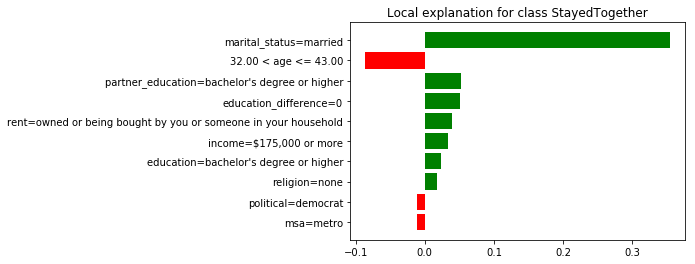

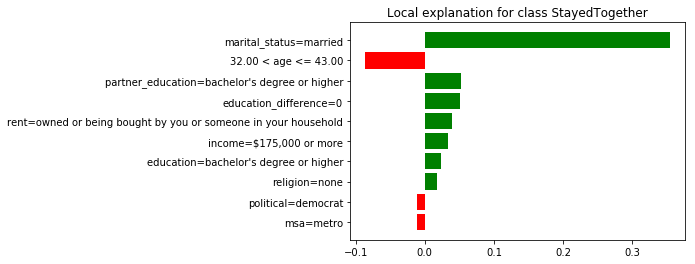

In [61]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()